本Colab NotebookはHuggingfaceで公開されているものに一部手を加えたものです。  
本家：https://huggingface.co/learn/cookbook/fine_tuning_vlm_dpo_smolvlm_instruct

変更点：無料版のT4で動作するように、以下の工夫を行いました。
- flash-attentionを除外（Ampare世代のGPUの場合は利用可能、高速化やメモリの削減が見込めますが、T4はflash-attentionの対象外です）
- 同上の理由で`_attn_implementation=None`とする
- ちなみに、bfloat16も使えないので、設定にある場合は自動的にfloat16にキャストされるとお考え下さい


# Fine-tuning SmolVLM using direct preference optimization (DPO) with TRL on a consumer GPU

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_


In this recipe, we’ll guide you through fine-tuning a **smol 🤏 Vision Language Model (VLM)** with **Direct Preference Optimization (DPO)** using the **Transformer Reinforcement Learning (TRL)** library to demonstrate how you can tailor VLMs to suit your specific needs, even when working with consumer-grade GPUs.

We’ll fine-tune [**SmolVLM**](https://huggingface.co/blog/smolvlm) using a **preference dataset** to help the model align with desired outputs. SmolVLM is a highly performant and memory-efficient model, making it an ideal choice for this task.  If you’re new to **Preference Optimization** for language or [vision-language models](https://huggingface.co/blog/vlms), check out [this blog](https://huggingface.co/blog/dpo_vlm) for an in-depth introduction.

The dataset we’ll use is [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted), which contains pairs of **`prompt + image`** along with a **`chosen`** and **`rejected`** answer for each pair. The goal of this fine-tuning process is to make the model consistently prefer the **chosen answers** from the dataset, reducing hallucinations.

This notebook has been tested using an **NVIDIA L4 GPU**.

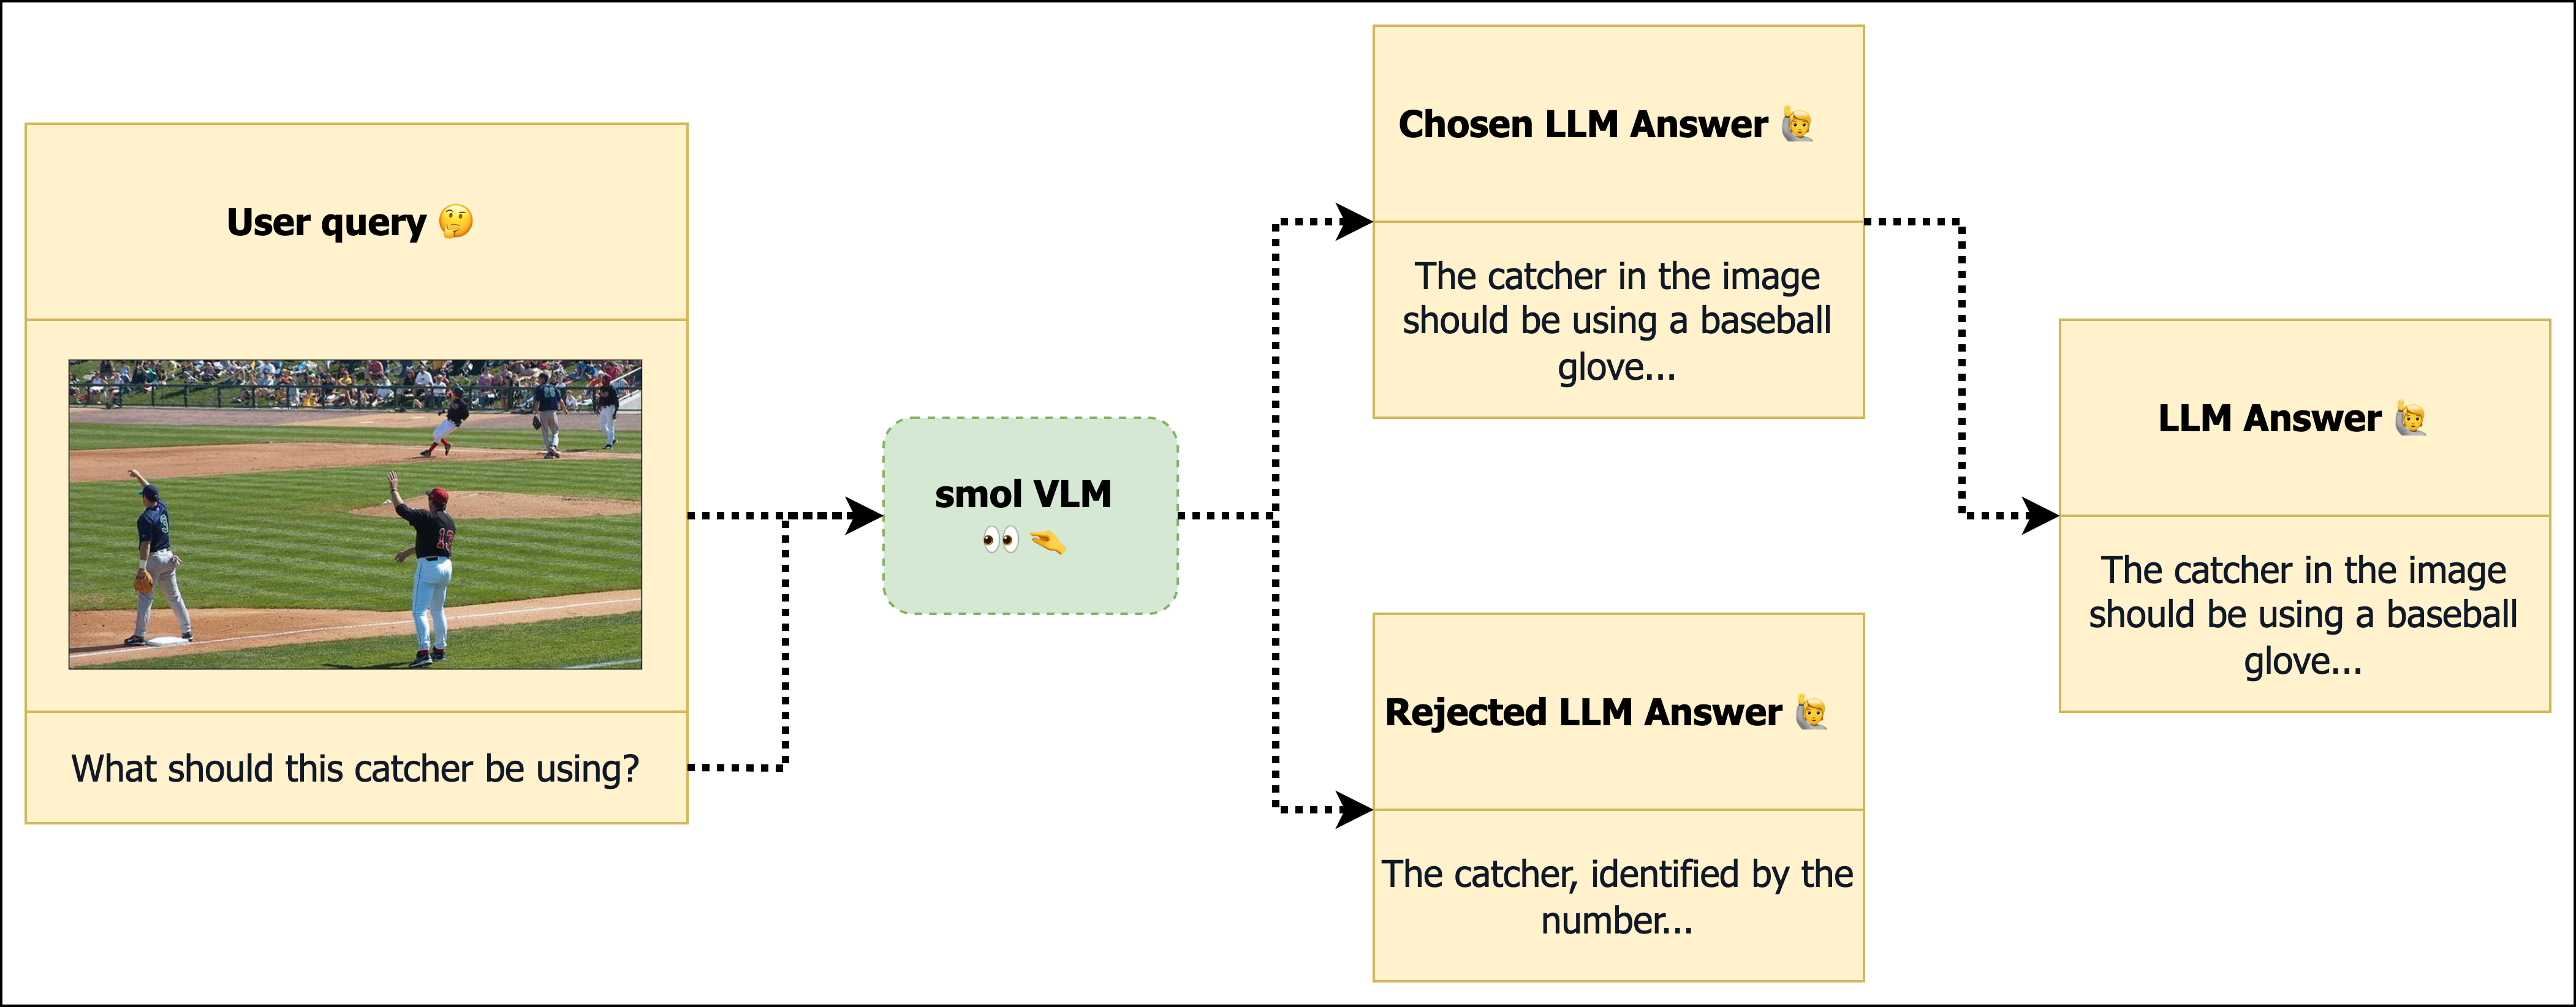

## 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀

In [1]:
!pip install -U -q transformers trl datasets bitsandbytes peft accelerate
# Tested with
# !pip install transformers==4.46.3, trl==0.12.2, datasets==3.2.0, bitsandbytes==0.45.0, peft==0.14.0, accelerate==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# !pip install -q flash-attn --no-build-isolation # flash attentionはT4で使えないのでコメントアウト

Authenticate with your Hugging Face account to save and share your model directly from this notebook 🗝️.

In [3]:
# from huggingface_hub import notebook_login

# notebook_login() HugingFaceにモデルをアップしたい場合などは使う。今回は除外

## 2. Load Dataset 📁

We’ll work with the [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted) dataset, which provides pairs of **`prompt + image`** along with a **`chosen`** and **`rejected`** answers for each pair. This structured format is ideal for training models with **Direct Preference Optimization (DPO)**.

The dataset is already preformatted for this task. If you’re working with a custom dataset, you’ll need to preprocess it into the same format.

In this example, we'll use a subset of the dataset to demonstrate the process. However, in a real-world scenario, you should utilize the full dataset for better performance.


In [2]:
from datasets import load_dataset

dataset_id = "HuggingFaceH4/rlaif-v_formatted"
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:6%]', 'test[:1%]'])

README.md:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

data/train-00000-of-00013.parquet:   0%|          | 0.00/569M [00:00<?, ?B/s]

data/train-00001-of-00013.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

data/train-00002-of-00013.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

data/train-00003-of-00013.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

data/train-00004-of-00013.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00005-of-00013.parquet:   0%|          | 0.00/531M [00:00<?, ?B/s]

data/train-00006-of-00013.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00007-of-00013.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00008-of-00013.parquet:   0%|          | 0.00/526M [00:00<?, ?B/s]

data/train-00009-of-00013.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

data/train-00010-of-00013.parquet:   0%|          | 0.00/518M [00:00<?, ?B/s]

data/train-00011-of-00013.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00012-of-00013.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/399M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78975 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4157 [00:00<?, ? examples/s]

We will ensure all the images are RGB formatted:

In [3]:
from PIL import Image

def ensure_rgb(example):
    # Convert the image to RGB if it's not already
    image = example['images'][0]
    if isinstance(image, Image.Image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        example['images'] = [image]
    return example

# Apply the transformation to the dataset
train_dataset = train_dataset.map(ensure_rgb, num_proc=4) # num_procはデータの処理の並列数、大きいと回らないのでColab無料枠では4～8くらいにしておく
test_dataset = test_dataset.map(ensure_rgb, num_proc=4)

Map (num_proc=4):   0%|          | 0/4738 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/42 [00:00<?, ? examples/s]

Let’s explore an example from the dataset to better understand its structure and the type of data we’re working with.


モデルの回答に対して損失を計算するための参照回答として**chosen**と**rejected**をデータセットの各サンプルに含めるのがDPOの特徴です

In [4]:
from pprint import pprint
pprint(train_dataset[20])

{'chosen': [{'content': [{'text': 'Yes, the grass in the image appears to be '
                                  'brown. This could indicate that the photo '
                                  'was taken during a dry season or in a '
                                  'region that experiences arid conditions. '
                                  'The brown grass contrasts with the grayish '
                                  'color of the elephant and provides a '
                                  'natural background that highlights the '
                                  "elephant's presence in its environment.",
                          'type': 'text'}],
             'role': 'assistant'}],
 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x78F4171A6D10>],
 'prompt': [{'content': [{'text': None, 'type': 'image'},
                         {'text': 'Does the grass have brown color?',
                          'type': 'text'}],
             'role': 'user'}],
 'r

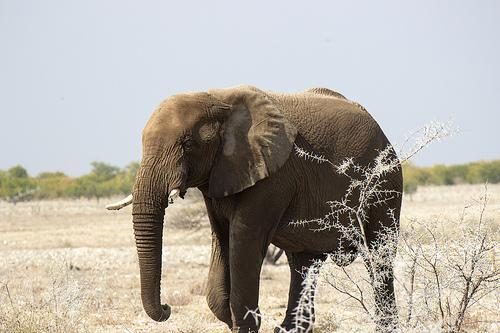

In [5]:
train_dataset[20]['images'][0]

## 3. Fine-Tune the Model using TRL



### 3.1 Load the Quantized Model for Training ⚙️


Let's first load a quantized version of the SmolVLM-Instruct model using bitsandbytes, and let's also load the processor. We'll use [SmolVLM-Instruct](https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct).

In [6]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

In [ ]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation=None, # _attn_implementation="flash_attention_2"をNoneに変更
)
processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.pad_token = processor.tokenizer.eos_token

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

### 3.2 Set Up QLoRA and DPOConfig 🚀

In this step, we’ll configure [QLoRA](https://github.com/artidoro/qlora) for our training setup. **QLoRA** is a powerful fine-tuning technique designed to reduce the memory footprint, making it possible to fine-tune large models efficiently, even on limited hardware.

QLoRA builds upon traditional **LoRA** (Low-Rank Adaptation) by introducing quantization for the adapter weights. This enhancement leads to significantly lower memory usage and faster training, making it an ideal choice for resource-constrained environments.


In [ ]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=True,
    init_lora_weights="gaussian"
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

Next, we will configure the training options using `DPOConfig`.

In [ ]:
from trl import DPOConfig

training_args = DPOConfig(
    output_dir="smolvlm-instruct-trl-dpo-rlaif-v",
    bf16=True,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=32,
    num_train_epochs=5,
    dataset_num_proc=8,  # tokenization will use 8 processes
    dataloader_num_workers=8,  # data loading will use 8 workers
    logging_steps=10,
    report_to="tensorboard",
    push_to_hub=False, # HuggingFaceHubにモデルをアップロードしないのならFalse
    save_strategy="steps",
    save_steps=10,
    save_total_limit=1,
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",
    padding_value=processor.tokenizer.eos_token_id,
)

We will define the training arguments for **Direct Preference Optimization (DPO)** with the [DPOTrainer](https://huggingface.co/docs/trl/dpo_trainer) class from the [TRL library](https://huggingface.co/docs/trl/index).

**DPO** uses labeled preference data to guide the model toward generating responses that align with preferences. TRL's [DPOTrainer](https://huggingface.co/docs/trl/dpo_trainer)  will **tokenize the dataset** before training and save it to disk. This process can consume significant disk space, depending on the amount of data used for training. Plan accordingly to avoid running out of storage.

This step may take a while, so feel free to relax and enjoy the process! 😄


In [ ]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=processor,
    peft_config=peft_config,
)

Time to train the model! 🎉

In [ ]:
trainer.train()

Let's save the results 💾

In [ ]:
trainer.save_model(training_args.output_dir)

## 4. Testing the Fine-Tuned Model 🔍

With our Vision Language Model (VLM) fine-tuned, it’s time to evaluate its performance! In this section, we’ll test the model using examples from the [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted) dataset. Let’s dive into the results and assess how well the model aligns with the preferred responses! 🚀

Before we begin, let’s clean up the GPU memory to ensure smooth and optimal performance. 🧹

In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

We will reload the base model using the same pipeline as before.

In [ ]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation=None, # _attn_implementation="flash_attention_2"をNoneに変更
)

processor = AutoProcessor.from_pretrained(model_id)

We will attach the trained adapter to the pretrained model. This adapter contains the fine-tuning adjustments made during training, enabling the base model to leverage the new knowledge while keeping its core parameters intact. By integrating the adapter, we enhance the model's capabilities without altering its original structure.

In [ ]:
adapter_path = "sergiopaniego/smolvlm-instruct-trl-dpo-rlaif-v"
model.load_adapter(adapter_path)

Let's evaluate the model on an unseen sample.


In [ ]:
test_dataset[20]

In [ ]:
test_dataset[20]['images'][0]

Let’s create a common function that we can call with different samples to streamline the testing process. This function will allow us to evaluate the model’s performance on multiple examples efficiently without needing to rewrite code for each one. By using this reusable function, we can quickly assess how well the model performs across a variety of inputs.



In [ ]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample['prompt'],
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample['images'][0]
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

Now, we’re ready to call the function and evaluate the model! 🚀

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[20])
output

The model is now able to generate responses based on the provided image and prompt. For tasks like this, it’s useful to compare your model's performance against a benchmark to see how much it has improved and how it stacks up against other options. For more information and details on this comparison, check out [this post](https://huggingface.co/blog/dpo_vlm#inference).

💻 I’ve developed an example application to test the model, which you can find [here](https://huggingface.co/spaces/sergiopaniego/SmolVLM-trl-dpo-rlaif-v).

Since here we only run an example training with a subset of the dataset, for the Space I've used the official [Hugging Face DPO fine tuned model](https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct-DPO). You can easily compare it with another Space featuring the pre-trained model, available [here](https://huggingface.co/spaces/HuggingFaceTB/SmolVLM).

In [ ]:
from IPython.display import IFrame

IFrame(src="https://sergiopaniego-smolvlm-trl-dpo-rlaif-v.hf.space", width=1000, height=800)

## 5. Continuing the Learning Journey 🧑‍🎓️

Expand your knowledge of Vision Language Models and related tools with these resources:

- **[Multimodal Recipes in the Cookbook](https://huggingface.co/learn/cookbook/index):** Discover practical recipes for multimodal models, including Retrieval-Augmented Generation (RAG) pipelines and fine-tuning. We’ve already published [a recipe for fine-tuning a smol VLM with TRL using SFT](https://huggingface.co/learn/cookbook/fine_tuning_smol_vlm_sft_trl), which complements this guide perfectly—check it out for additional details.
  
- **[TRL Community Tutorials](https://huggingface.co/docs/trl/main/en/community_tutorials):** Explore a rich collection of tutorials that dive into the intricacies of TRL and its real-world applications.

You can also revisit the _Continuing the Learning Journey_ section in [Fine-Tuning a Vision Language Model (Qwen2-VL-7B) with the Hugging Face Ecosystem (TRL)](https://huggingface.co/learn/cookbook/fine_tuning_vlm_trl).

These resources will help deepen your knowledge and expertise in multimodal learning.



